/root/anaconda3/envs/lensless/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of files : 999
PSF shape : torch.Size([1, 135, 240, 3])
PSF range : [0.0 - 0.12337537109851837]


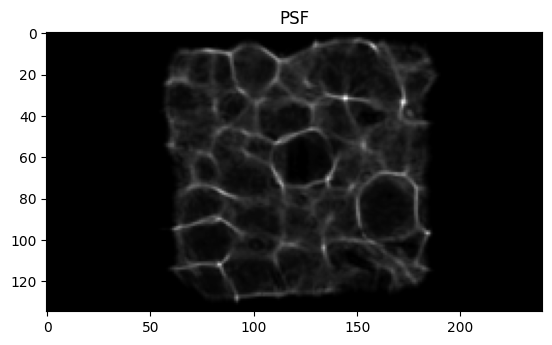

In [1]:
import matplotlib.pyplot as plt
from lensless.utils.plot import plot_image
from lensless.utils.dataset import get_dataset

CACHE_DIR = None   # path to download dataset, by default it is stored in ~/.cache/huggingface/datasets
dataset = "diffusercam_mirflickr"

# load test set
test_set = get_dataset(
    dataset_name=dataset,
    split="test", 
    cache_dir=CACHE_DIR
)

print(f"Number of files : {len(test_set)}")
print(f"PSF shape : {test_set.psf.shape}")
print(f"PSF range : [{test_set.psf.min()} - {test_set.psf.max()}]")

psf = test_set.psf.numpy().squeeze()   # drop extra dimension for depth

# plot PSF
plot_image(psf, gamma=2)
plt.title("PSF");

PSF shape : (135, 240, 3)
[(22, 40), (22, 120), (22, 200), (67, 40), (67, 120), (67, 200), (112, 40), (112, 120), (112, 200)]


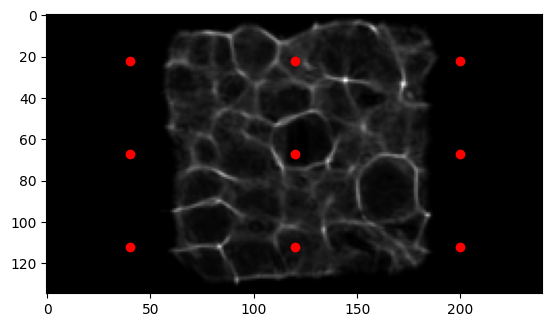

In [2]:
K = 3
Nx, Ny = psf.shape[:2]

# get centers of KxK patches
print(f"PSF shape : {psf.shape}")
centers = []
for i in range(K):
    for j in range(K):
        centers.append((int((i+0.5)*Nx/K), int((j+0.5)*Ny/K)))
print(centers)

# plot centers as red dots
ax = plot_image(psf, gamma=2)
for center in centers:
    ax.plot(center[1], center[0], 'ro')

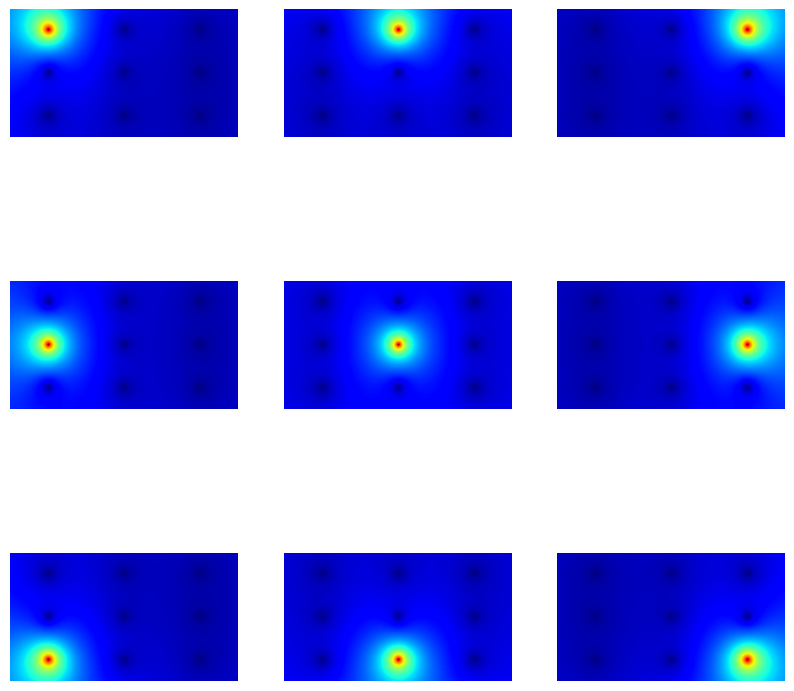

In [3]:
import numpy as np

Y, X = np.meshgrid(np.arange(Ny), np.arange(Nx))

# compute weight matrices
eps = 1e-4
weight_mat = []
for center in centers:
    weight = ((X-center[0])**2 + (Y-center[1])**2 + eps) ** (-0.5)
    weight_mat.append(weight)

# normalize weight matrices
sum_weights = np.sum(weight_mat, axis=0)
for i in range(K*K):
    weight_mat[i] /= sum_weights

# plot array of weight matrices
cmap = "jet"   # "gray"
fig, ax = plt.subplots(K, K, figsize=(10, 10))
for i in range(K):
    for j in range(K):
        ax[i, j].imshow(weight_mat[i*K+j], cmap=cmap)
        ax[i, j].axis('off')

# check that sums to 1 at each pixel
sum_mat = np.sum(weight_mat, axis=0)
assert np.allclose(sum_mat, 1.0)